2022年香港中文大学的论文《Are Transformers Effective for Time Series Forecasting?》仅仅用最简单的Linear模型就结结实实的打脸了一众Transformer-based 模型，

最尴尬的是，在汇率预测上，一个简单的用昨天预测今天，或者上一个周期预测下一个周期的策略竟然比所有Transformer模型都表现得更好。这不禁让人怀疑，这些所谓的Transformer based究竟是在真的学习序列特征，还是只是在过拟合噪声，然后选择拟合的比较好的那些发表。

Transformer在NLP中的成功是基于其提取序列元素间语义相关性的能力。然而，时间序列数据本身通常缺乏语义，其核心在于建模连续点集中的时间关系，其中序列本身扮演着最关键的角色。

在自然语言中，即使完全打乱单词顺序，单纯的词义就可以反映相当多的原句的语义，Tramsformer模型再利用位置编码，建模词义之间的相对关系所带来的深层词义，来完成整个句子语义的处理。虽然位置编码可以保留一部分序列信息，但总归是有转换和丢失的。

面对时序数据，一个完全被打乱的序列，几乎丢掉了99%的信息，换言之时序数据的信息大部分都隐藏在相关关系中。在这种情况下，再去强行追求former系的并行性，用低效率的位置编码尝试保留序列信息，相当于是买椟还珠，本末倒置了。堆叠各种复杂的模型，并不一定就能取得更优的效果，更多只是基于发论文视角的为了创新而创新。

因此，在dive into deep learning 的各种 “former” 之前，需要先用传统的统计学工具建立一个科学而合理的基线模型，来区分哪些是真正有价值的，哪些只是花里胡哨的。



我们结合前述的所有框架，采用最简单的线性模型DLinear作为编码器，建立一个基线模型

在随机选取的数据区间和随机训练上，得到了平均11.65% (std 1.97%) 的超额预测准确率：即在做出预测的情况下（分类0 和分类2中），预测正确的概率超出预测完全错误的比例。

当然，这个模型还有一定的缺陷，比如做出预测的比例只有20%不到，大部分时间都会因为不能自信做出预测而选择放弃。

这个数字可以作为一个良好的模型评估基准，如果更为复杂的模型的准确率没有这样的效果，那就不得不思考当前的模型是否有效了

In [1]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from torch.utils.data import TensorDataset, DataLoader

from utils.random_split import RandomSplit, CallableDataset
from utils.back_test import BackTest
from utils.hybrid_loss import HybridLoss
from utils.hybrid_decoder import HybridDecoder
from utils.prediction_recorder import PredictionRecorder
from utils.train_animator import TrainAnimator
from utils.model_train import ModelTrain
from utils.balance_sampler import BalancedSampler

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
seq_len = 40

In [3]:
feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
label_columns = ['label_return','down_prob','middle_prob','up_prob']
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX',]

In [4]:
feature = []
label = []

for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
    label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

# 加载数据
feature = torch.stack(feature, dim = 1)
label = torch.stack(label, dim = 1)
print(feature.shape, label.shape)

# 折叠时间步
feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
label = label[seq_len-1:]
# 归并品种
feature = torch.flatten(feature, start_dim=0, end_dim = 1)
label = torch.flatten(label, start_dim=0, end_dim = 1)

feature.shape, label.shape

torch.Size([2603, 3, 10]) torch.Size([2603, 3, 4])


(torch.Size([7692, 40, 10]), torch.Size([7692, 4]))

In [5]:
train_size = int(0.5*len(feature))
validation_size = int(0.2*len(feature))
test_size  = int(0.1*len(feature))

split = np.random.randint(train_size, len(feature) - validation_size - test_size)
print(split, train_size, validation_size, test_size)

train_set = TensorDataset(feature[:split], label[:split])
balance_sampler = BalancedSampler(label[:split], 64)
train_loader = DataLoader(train_set, batch_sampler=balance_sampler)

validation_set = TensorDataset(feature[split:split+validation_size], label[split:split+validation_size])
validation_loader = DataLoader(validation_set, batch_size=100)

test_set = TensorDataset(feature[split+validation_size:split+validation_size+test_size], label[split+validation_size:split+validation_size+test_size])
test_loader = DataLoader(test_set, batch_size=100)

5041 3846 1538 769


In [6]:
from modules.dlinear import DLinear
class DLinearOutput(nn.Module):
    """循环神经网络模型"""
    def __init__(self, seq_len, pred_len, individual, enc_in, kernel_size, init_prob, dropout, **kwargs):
        super(DLinearOutput, self).__init__(**kwargs)
        self.device = 'cuda:0'

        self.process = nn.Sequential(
            DLinear(seq_len = seq_len, pred_len =  pred_len, individual = individual, enc_in = enc_in, kernel_size = kernel_size),
            nn.Sequential(nn.Flatten(start_dim = 1), nn.Dropout(dropout))
            )

        self.output = HybridDecoder(pred_len * enc_in, init_prob = init_prob)

    def forward(self, x):
        x = self.process(x)
        return self.output(x)

In [7]:
recorder = PredictionRecorder()
animator = TrainAnimator(figsize=(12,6))

Animator data has been reset.


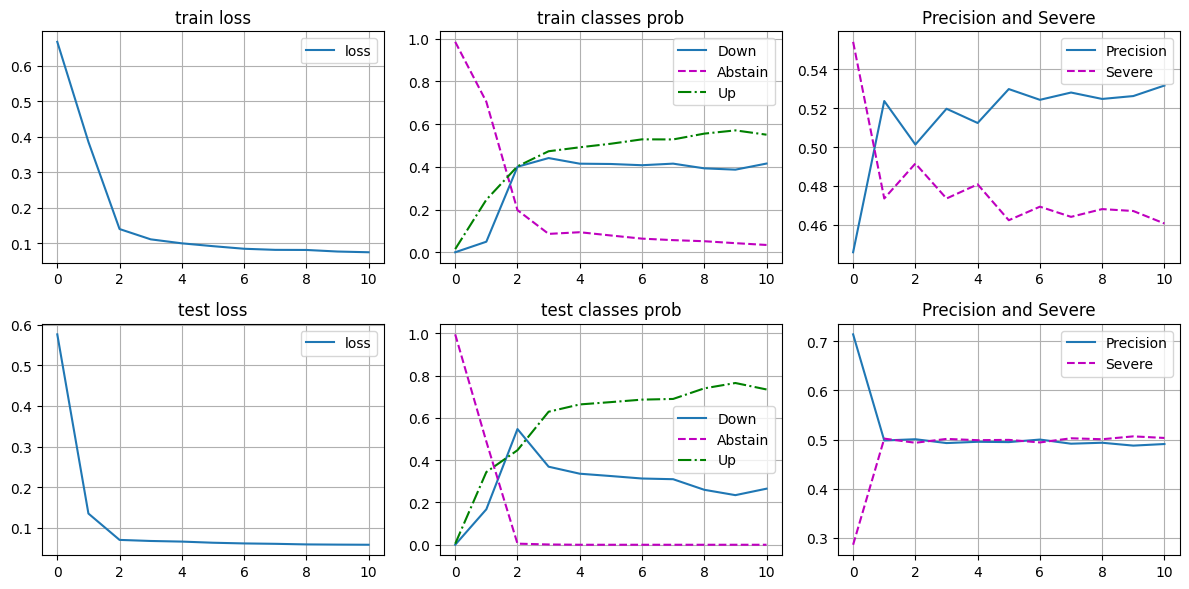

100%|██████████| 8/8 [00:00<00:00, 184.33it/s]


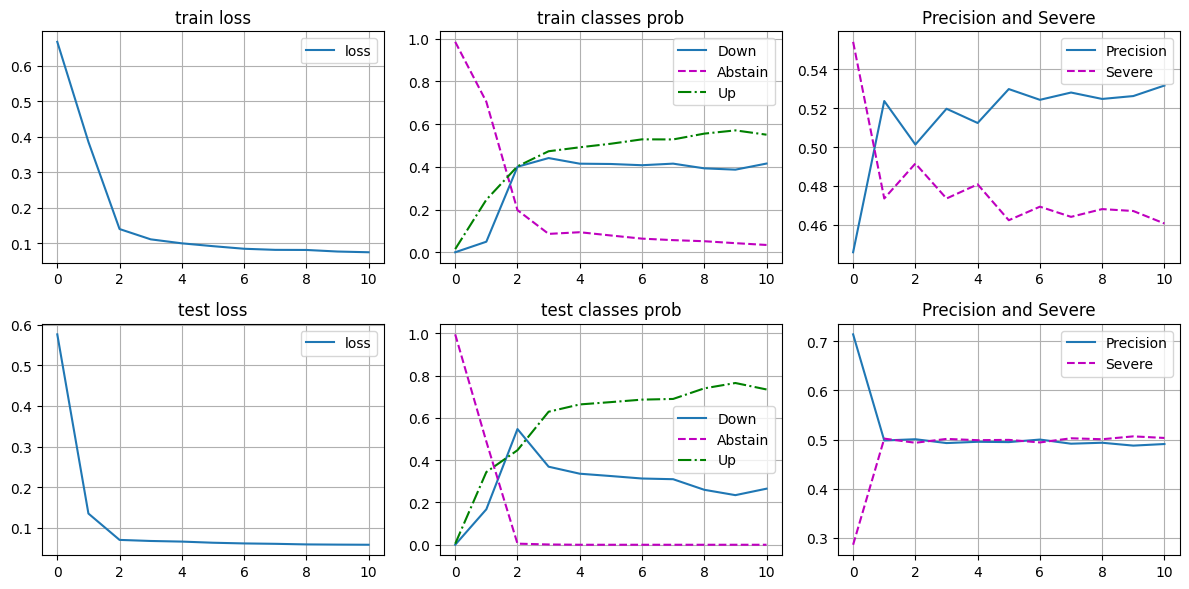

In [8]:
gap = []
for i in range(10):

    train_size = int(0.5*len(feature))
    validation_size = int(0.2*len(feature))
    test_size  = int(0.1*len(feature))

    split = np.random.randint(train_size, len(feature) - validation_size - test_size)

    train_set = TensorDataset(feature[:split], label[:split])
    balance_sampler = BalancedSampler(label[:split], 256)
    train_loader = DataLoader(train_set, batch_sampler=balance_sampler)

    validation_set = TensorDataset(feature[split:split+validation_size], label[split:split+validation_size])
    validation_loader = DataLoader(validation_set, batch_size=100)

    test_set = TensorDataset(feature[split+validation_size:split+validation_size+test_size], label[split+validation_size:split+validation_size+test_size])
    test_loader = DataLoader(test_set, batch_size=100)

    
    animator.reset()
    loss_fn = HybridLoss(alpha = 1e-5, delta = 1)
    model = DLinearOutput(seq_len = seq_len, pred_len = 5, individual = True, enc_in = 10, kernel_size = 21, init_prob = [0.0, 1, 0.0], dropout = 0.5).to('cuda:0')
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-1)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
    train = ModelTrain(model = model,
                   train_loader = train_loader,
                   validation_loader = validation_loader,
                   test_loader = test_loader,
                   loss_fn = loss_fn,
                   optimizer = optimizer,
                   scheduler = scheduler,
                   recorder = recorder,
                   graph = animator,
                   )
    precision, severe = train.epoch_train(epochs = 10, early_stop = 5)

    gap.append(precision - severe)


In [9]:
print(f'超额正确率均值  ：{np.mean(gap):.2%}')
print(f'超额正确率标准差：{np.std(gap):.2%}')

超额正确率均值  ：98.56%
超额正确率标准差：6.51%


In [10]:
# torch.save(model.state_dict(), 'params/baseline.params')